In [1]:
%matplotlib inline

In [351]:
import pandas as pd
import os
from functools import reduce
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats.stats import pearsonr
from scipy import stats
from scipy.stats import ks_2samp
from scipy.stats import entropy
from scipy.stats import norm
from scipy.stats import lognorm
from scipy.stats import nbinom
from scipy.stats.mstats import gmean

import math


from pandas.tools.plotting import scatter_matrix

### This lesson analyzes data from the following paper

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4878611/pdf/839.pdf

#### How many biological replicates are needed in an RNA-seq experiment and which differential expression tool should you use?

RNA-seq is now the technology of choice for genome-wide differential gene expression experiments, but it is not clear how many biological replicates are needed to ensure valid biological interpretation of the results or which statistical tools are best for analyzing the data. An RNA-seq experiment with 48 biological replicates in each of two conditions was performed to answer these questions and provide guidelines for experimental design. With three biological replicates, nine of the 11 tools evaluated found only 20%–40% of the significantly differentially expressed (SDE) genes identified with the full set of 42 clean replicates. This rises to >85% for the subset of SDE genes changing in expression by more than fourfold. To achieve >85% for all SDE genes regardless of fold change requires more than 20 biological replicates. The same nine tools successfully control their false discovery rate at ≲5% for all numbers of replicates, while the remaining two tools fail to control their FDR adequately, particularly for low numbers of replicates. For future RNA-seq experiments, these results suggest that at least six biological replicates should be used, rising to at least 12 when it is important to identify SDE genes for all fold changes. If fewer than 12 replicates are used, a superior combination of true positive and false positive performances makes edgeR and DESeq2 the leading tools. For higher replicate numbers, minimizing false positives is more important and DESeq marginally outperforms the other tools.

### Datafiles

There are 96 separate datafiles, each representing the processed output of an RNAseq experiment looking at mRNA levels in wild-type (48 samples) or SNF2 deletion (48 samples) yeast cells grown under standard condition. 

The files are incredible simple. Two columns, separated by tabs. The first column is the gene name, the second column the normalized counts for that gene in that sample (read the paper if you're interested in how they did the counting and normalization).

YBL013W 39
YBL014C 127
YBL015W 732
YBL016W 309
YBL017C 1613
YBL018C 174
YBL019W 117
YBL020W 258
YBL021C 248
YBL022C 1168
YBL023C 331
YBL024W 451
YBL025W 64
YBL026W 206
YBL027W 9723
YBL028C 77
YBL029C-A       157

Most of the genes have this naming format:

Systematic names for nuclear-encoded ORFs begin with the letter 'Y' (for 'Yeast'); the second letter denotes the chromosome number ('A' is chr I, 'B' is chr II, etc.); the third letter is either 'L' or 'R' for left or right chromosome arm; next is a three digit number indicating the order of the ORFs on that arm of a chromosome starting from the centromere, irrespective of strand; finally, there is an additional letter indicating the strand, either 'W' for Watson (the strand with 5' end at the left telomere) or 'C' for Crick (the complement strand, 5' end is at the right telomere).

You can read about the yeast gene naming system here - http://seq.yeastgenome.org/help/community/nomenclature-conventions. 

In [231]:
# 
# Input data are in individual tab-delimited files, one for each experiment
# Here I load each one into its own Pandas dataframe and create a list of frames
#

frames = []

for file in os.listdir("Data"):
    if file.endswith(".gbgout"):
        filepath = os.path.join("Data/", file)
        fs = file.split('_')
        name = "_".join(fs[0:2])
        frames.append(pd.read_csv(filepath, sep="\t", header = None, names=['Gene',name]))

In [232]:
#
# Combines all of the individual frames into one dataframe, combining on the "Gene" column
# Column names are the data file
#

df = reduce(lambda  left,right: pd.merge(left,right,on=['Gene'], how='outer'), frames)

In [233]:
#
# Sort columns by name for convenience
#

df = df.reindex(sorted(df.columns), axis=1)

In [234]:
#
# Use only genes starting with "Y" which are protein-coding genes
# You can come back and revisit this choice later if you want
#

df = df.loc[df['Gene'].str.startswith('Y')]

In [235]:
#
# Index dataframe on 'Gene'
#

df = df.set_index('Gene')

In [236]:
# Save so we don't have to do all that again next time

df.to_csv("Barton_combined_Ygenes.txt", sep='\t')

In [237]:
# remove outliers 

colnames = df.columns.get_values()

colnames_filt = []
for c1 in colnames:
    d = []
    for c2 in colnames:
        d.append(pearsonr(df[c1],df[c2])[0])
    d = np.array(d)
    if np.mean(d) < 0.95:
        print ("Removing ",c1,np.mean(d))
    else:
        colnames_filt.append(c1)
        
colnames = colnames_filt

Removing  Snf2_rep06 0.691487784223
Removing  Snf2_rep13 0.803427905697
Removing  Snf2_rep35 0.932471392569
Removing  WT_rep21 0.764104671143
Removing  WT_rep22 0.933839516889
Removing  WT_rep25 0.86363576014
Removing  WT_rep28 0.891720439048


In [238]:
# now create lists for WT and Snf2 so we can start comparing them

colnames_snf2 = []
colnames_WT = []

for c in colnames:
    if c.startswith("Snf2"):
        colnames_snf2.append(c)
    elif c.startswith("WT"):
        colnames_WT.append(c)

In [239]:
# for convenience, create new columns that are averages of each type and overall

df['Snf2_ave'] = df[colnames_snf2].mean(axis=1)
df['WT_ave'] = df[colnames_WT].mean(axis=1)
df['ave'] = df[colnames_snf2 + colnames_WT].mean(axis=1)



In [240]:
#
# time to relook at normalization
#

df['Gmean'] = gmean(df.loc[:,colnames_WT],axis=1)


/Users/eisen/anaconda/lib/python3.5/site-packages/scipy/stats/stats.py:305: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(np.array(a, dtype=dtype))


In [241]:
colnorm = {}

for c in colnames:
    colnorm[c] = np.median((df[c]/df['Gmean']).replace([np.inf, -np.inf], np.nan).dropna())

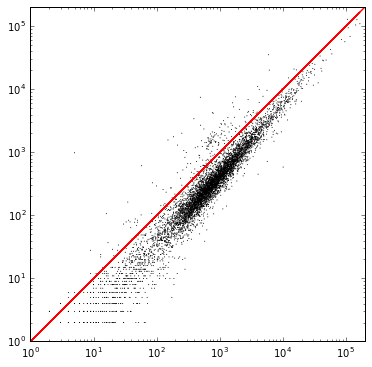

In [242]:
# let's pick a pair of WT and snf2 experiments and see how they compare

# how well do these fit?

c1 = 'Snf2_rep01'
c2 = 'WT_rep01'

# select data, remove really low values

x = df[c1]
y = df[c2]

maxval = max(np.max(x),np.max(y))

fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(1,1,1)
ax.set_xlim(1,maxval)
ax.set_ylim(1,maxval)
ax.set_xscale("log", nonposx='clip')
ax.set_yscale("log", nonposx='clip')
ax.scatter(x, y, s = 1, c = 'black', edgecolor = 'none')
ax.plot(x,x,'r-')

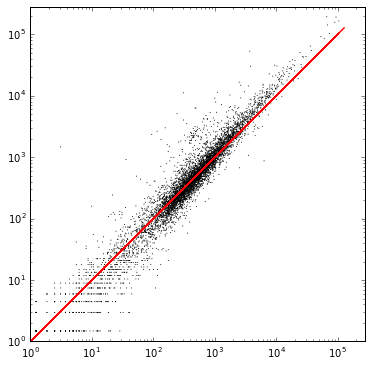

In [243]:
# let's pick a pair of WT and snf2 experiments and see how they compare

# how well do these fit?

c1 = 'Snf2_rep01'
c2 = 'WT_rep01'

# select data, remove really low values

x = df[c1]/colnorm[c1]
y = df[c2]/colnorm[c2]

maxval = max(np.max(x),np.max(y))

fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(1,1,1)
ax.set_xlim(1,maxval)
ax.set_ylim(1,maxval)
ax.set_xscale("log", nonposx='clip')
ax.set_yscale("log", nonposx='clip')
ax.scatter(x, y, s = 1, c = 'black', edgecolor = 'none')
ax.plot(x,x,'r-')

In [244]:
for c in colnames:
    df[c] = df[c]/colnorm[c]

In [300]:
df['WT_ave'] = df[colnames_WT].mean(axis=1)
df['WT_var'] = df[colnames_WT].var(axis=1)
df['WT_sum'] = df[colnames_WT].sum(axis=1)
df['WT_std'] = df[colnames_WT].std(axis=1)

df['Snf2_ave'] = df[colnames_snf2].mean(axis=1)
df['Snf2_var'] = df[colnames_snf2].var(axis=1)
df['Snf2_sum'] = df[colnames_snf2].sum(axis=1)

df['ave'] = df[colnames_snf2 + colnames_WT].mean(axis=1)
df['var'] = df[colnames_snf2 + colnames_WT].var(axis=1)
df['sum'] = df[colnames_snf2 + colnames_WT].sum(axis=1)

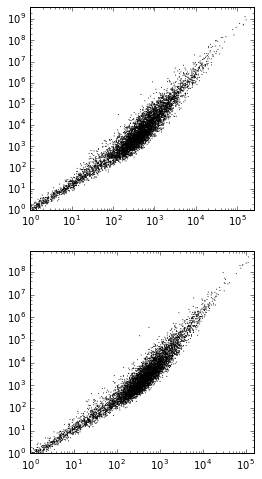

In [257]:
fig,axes = plt.subplots(2,1,figsize = (4,8))
x = df['WT_ave']
y = df['WT_var']

maxval = max(np.max(x),np.max(y))
axes[0].set_xlim(1,np.max(x))
axes[0].set_ylim(1,np.max(y))
axes[0].set_xscale("log", nonposx='clip')
axes[0].set_yscale("log", nonposx='clip')
axes[0].scatter(x,y, s = 1, c = 'black', edgecolor = 'none')

x = df['Snf2_ave']
y = df['Snf2_var']

maxval = max(np.max(x),np.max(y))
axes[1].set_xlim(1,np.max(x))
axes[1].set_ylim(1,np.max(y))
axes[1].set_xscale("log", nonposx='clip')
axes[1].set_yscale("log", nonposx='clip')
axes[1].scatter(x,y, s = 1, c = 'black', edgecolor = 'none')

In [216]:
WT_sum1s = 0
snf2_sum1s = 0

for c in colnames_WT:
    WT_sum1s += 1.0/norm[c]
    
WT_sum1s /= len(colnames_WT)

for c in colnames_snf2:
    snf2_sum1s += 1.0/norm[c]
    
snf2_sum1s /= len(colnames_snf2)
    
df['WT_z'] = df['WT_n_ave'] / WT_sum1s
df['Snf2_z'] = df['Snf2_n_ave'] / WT_sum1s

df['WT_vest'] = df['WT_n_var'] - df['WT_z']
df['Snf2_vest'] = df['Snf2_n_var'] - df['Snf2_z']

In [376]:
colnames_WT_t = list(np.random.choice(colnames_WT,3))
colnames_snf2_t = list(np.random.choice(colnames_snf2,3))

df['WT_ave_t'] = df[colnames_WT_t].mean(axis=1)
df['WT_var_t'] = df[colnames_WT_t].var(axis=1)
df['WT_sum_t'] = df[colnames_WT_t].sum(axis=1)


df['Snf2_ave_t'] = df[colnames_snf2_t].mean(axis=1)
df['Snf2_var_t'] = df[colnames_snf2_t].var(axis=1)
df['Snf2_sum_t'] = df[colnames_snf2_t].sum(axis=1)

df['ave_t'] = df[colnames_snf2_t + colnames_WT_t].mean(axis=1)
df['var_t'] = df[colnames_snf2_t + colnames_WT_t].var(axis=1)
df['sum_t'] = df[colnames_snf2_t + colnames_WT_t].sum(axis=1)

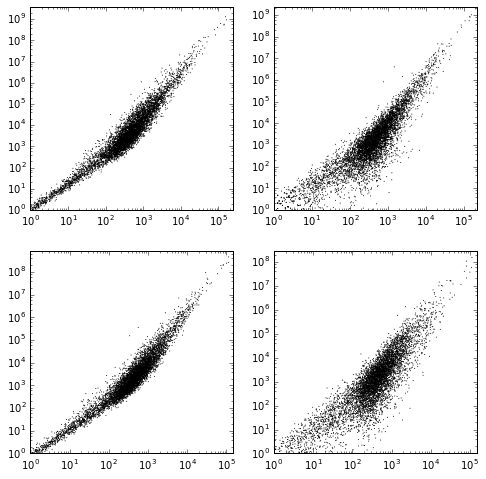

In [377]:
fig,axes = plt.subplots(2,2,figsize = (8,8))

x = df['WT_ave']
y = df['WT_var']

maxval = max(np.max(x),np.max(y))
axes[0][0].set_xlim(1,np.max(x))
axes[0][0].set_ylim(1,np.max(y))
axes[0][0].set_xscale("log", nonposx='clip')
axes[0][0].set_yscale("log", nonposx='clip')
axes[0][0].scatter(x,y, s = 1, c = 'black', edgecolor = 'none')

x = df['Snf2_ave']
y = df['Snf2_var']

maxval = max(np.max(x),np.max(y))
axes[1][0].set_xlim(1,np.max(x))
axes[1][0].set_ylim(1,np.max(y))
axes[1][0].set_xscale("log", nonposx='clip')
axes[1][0].set_yscale("log", nonposx='clip')
axes[1][0].scatter(x,y, s = 1, c = 'black', edgecolor = 'none')

x = df['WT_ave_t']
y = df['WT_var_t']

maxval = max(np.max(x),np.max(y))
axes[0][1].set_xlim(1,np.max(x))
axes[0][1].set_ylim(1,np.max(y))
axes[0][1].set_xscale("log", nonposx='clip')
axes[0][1].set_yscale("log", nonposx='clip')
axes[0][1].scatter(x,y, s = 1, c = 'black', edgecolor = 'none')

x = df['Snf2_ave_t']
y = df['Snf2_var_t']

maxval = max(np.max(x),np.max(y))
axes[1][1].set_xlim(1,np.max(x))
axes[1][1].set_ylim(1,np.max(y))
axes[1][1].set_xscale("log", nonposx='clip')
axes[1][1].set_yscale("log", nonposx='clip')
axes[1][1].scatter(x,y, s = 1, c = 'black', edgecolor = 'none')

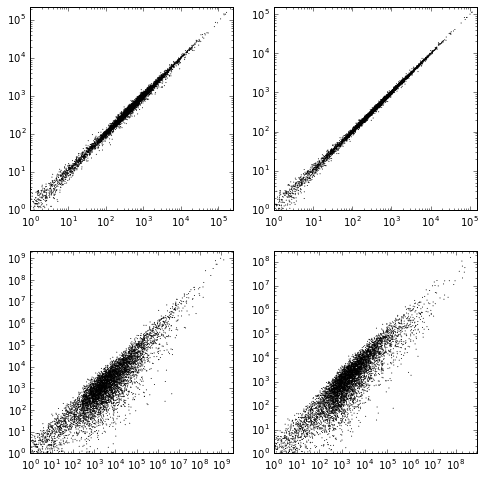

In [378]:
fig,axes = plt.subplots(2,2,figsize = (8,8))

x = df['WT_ave']
y = df['WT_ave_t']
i = 0
j = 0

maxval = max(np.max(x),np.max(y))
axes[i][j].set_xlim(1,np.max(x))
axes[i][j].set_ylim(1,np.max(y))
axes[i][j].set_xscale("log", nonposx='clip')
axes[i][j].set_yscale("log", nonposx='clip')
axes[i][j].scatter(x,y, s = 1, c = 'black', edgecolor = 'none')


x = df['WT_var']
y = df['WT_var_t']
i = 1
j = 0

maxval = max(np.max(x),np.max(y))
axes[i][j].set_xlim(1,np.max(x))
axes[i][j].set_ylim(1,np.max(y))
axes[i][j].set_xscale("log", nonposx='clip')
axes[i][j].set_yscale("log", nonposx='clip')
axes[i][j].scatter(x,y, s = 1, c = 'black', edgecolor = 'none')

x = df['Snf2_ave']
y = df['Snf2_ave_t']
i = 0
j = 1

maxval = max(np.max(x),np.max(y))
axes[i][j].set_xlim(1,np.max(x))
axes[i][j].set_ylim(1,np.max(y))
axes[i][j].set_xscale("log", nonposx='clip')
axes[i][j].set_yscale("log", nonposx='clip')
axes[i][j].scatter(x,y, s = 1, c = 'black', edgecolor = 'none')


x = df['Snf2_var']
y = df['Snf2_var_t']
i = 1
j = 1

maxval = max(np.max(x),np.max(y))
axes[i][j].set_xlim(1,np.max(x))
axes[i][j].set_ylim(1,np.max(y))
axes[i][j].set_xscale("log", nonposx='clip')
axes[i][j].set_yscale("log", nonposx='clip')
axes[i][j].scatter(x,y, s = 1, c = 'black', edgecolor = 'none')

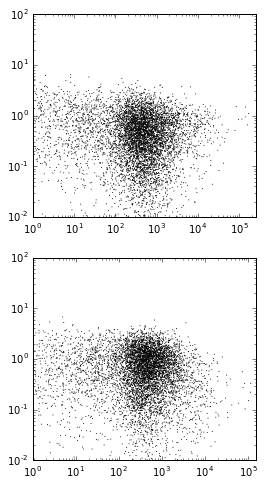

In [383]:
fig,axes = plt.subplots(2,1,figsize = (4,8))

x = df['WT_ave']
y = df['WT_var_t'] / df['WT_var']
i = 0

maxval = max(np.max(x),np.max(y))
axes[i].set_xlim(1,np.max(x))
axes[i].set_ylim(.01,100)
axes[i].set_xscale("log", nonposx='clip')
axes[i].set_yscale("log", nonposx='clip')
axes[i].scatter(x,y, s = 1, c = 'black', edgecolor = 'none')


x = df['Snf2_ave']
y = df['Snf2_var_t'] / df['Snf2_var']
i = 1

maxval = max(np.max(x),np.max(y))
axes[i].set_xlim(1,np.max(x))
axes[i].set_ylim(.01,100)
axes[i].set_xscale("log", nonposx='clip')
axes[i].set_yscale("log", nonposx='clip')
axes[i].scatter(x,y, s = 1, c = 'black', edgecolor = 'none')



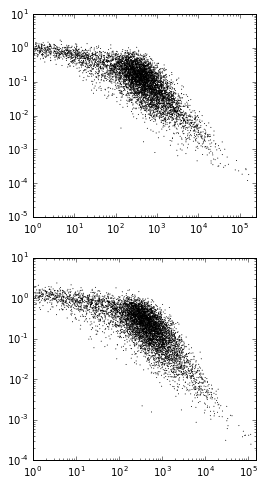

In [284]:
fig,axes = plt.subplots(2,1,figsize = (4,8))

x = df['WT_ave']
y = df['WT_ave']/df['WT_var']
i = 0

maxval = max(np.max(x),np.max(y))
axes[i].set_xlim(1,np.max(x))
#axes[i].set_ylim(1,np.max(y))
axes[i].set_xscale("log", nonposx='clip')
axes[i].set_yscale("log", nonposx='clip')
axes[i].scatter(x,y, s = 1, c = 'black', edgecolor = 'none')


x = df['Snf2_ave']
y = df['Snf2_ave']/df['Snf2_var']
i = 1

maxval = max(np.max(x),np.max(y))
axes[i].set_xlim(1,np.max(x))
#axes[i].set_ylim(1,np.max(y))
axes[i].set_xscale("log", nonposx='clip')
axes[i].set_yscale("log", nonposx='clip')
axes[i].scatter(x,y, s = 1, c = 'black', edgecolor = 'none')


In [320]:
# let's look at what kind of distribution best describes the data

df2 = df[colnames_WT].subtract(df['WT_ave'],axis=0).divide(df['WT_std'],axis=0)
df2 = df2[df['WT_ave'] > 100]

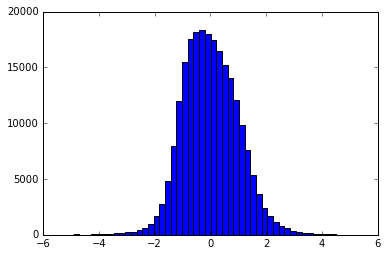

In [323]:
data = np.ravel(df2.replace([np.inf, -np.inf], np.nan).dropna().values)
h = plt.hist(data,bins=50)

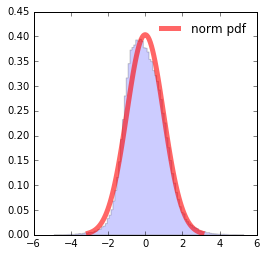

In [329]:
fig, ax = plt.subplots(1,1,figsize=(4,4))

mean_fit, var_fit = norm.fit(data)

rv = norm(mean_fit,var_fit)
x = np.linspace(rv.ppf(0.001),rv.ppf(0.999), 100)

ax.plot(x, rv.pdf(x),'r-', lw=5, alpha=0.6, label='norm pdf')
ax.hist(data, normed=True, histtype='stepfilled', bins = 100, alpha=0.2)
ax.legend(loc='best', frameon=False)
df[plt.show()

In [387]:
n1 = float(len(colnames_WT))
n2 = float(len(colnames_snf2))

df['z_score'] = df['colnames_']



for index, row in df.iterrows():
    snf2 = row[colnames_snf2]
    wt = row[colnames_WT]
    
    #zscore = (np.mean(wt)-np.mean(snf2))/np.sqrt((row['WT_var']/n1) + (row['Snf2_var']/n2))
    if not math.isnan(zscore):
        row['z_score'] = zscore

/Users/eisen/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in double_scalars


In [413]:
n1 = float(len(colnames_WT))
n2 = float(len(colnames_snf2))

df['z_score'] = (df[colnames_WT].mean(axis=1) - df[colnames_snf2].mean(axis=1))/np.sqrt((df['WT_var']/n1) + (df['Snf2_var']/n2))

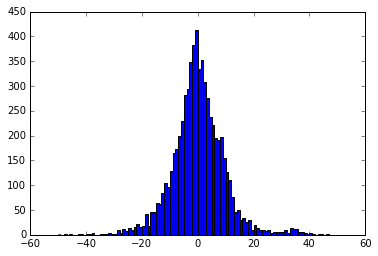

In [422]:
data = df['z_score']
h = plt.hist(data,bins=np.arange(-50,50,1))

In [427]:
colnames_WT_t = list(np.random.choice(colnames_WT,20))
colnames_snf2_t = list(np.random.choice(colnames_snf2,20))

df['WT_ave_t'] = df[colnames_WT_t].mean(axis=1)
df['WT_var_t'] = df[colnames_WT_t].var(axis=1)
df['WT_sum_t'] = df[colnames_WT_t].sum(axis=1)


df['Snf2_ave_t'] = df[colnames_snf2_t].mean(axis=1)
df['Snf2_var_t'] = df[colnames_snf2_t].var(axis=1)
df['Snf2_sum_t'] = df[colnames_snf2_t].sum(axis=1)

df['ave_t'] = df[colnames_snf2_t + colnames_WT_t].mean(axis=1)
df['var_t'] = df[colnames_snf2_t + colnames_WT_t].var(axis=1)
df['sum_t'] = df[colnames_snf2_t + colnames_WT_t].sum(axis=1)

n1 = float(len(colnames_WT_t))
n2 = float(len(colnames_snf2_t))

df['z_score_t'] = (df[colnames_WT_t].mean(axis=1) - df[colnames_snf2_t].mean(axis=1))/np.sqrt((df['WT_var_t']/n1) + (df['Snf2_var_t']/n2))

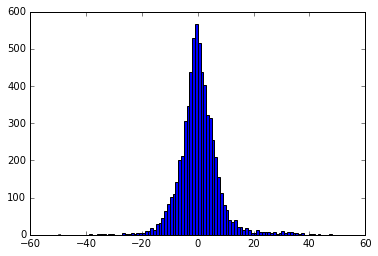

In [428]:
data = df['z_score_t']
h = plt.hist(data,bins=np.arange(-50,50,1))

(-20, 20)

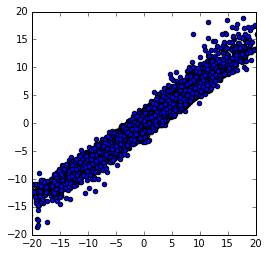

In [429]:
fig,ax = plt.subplots(1,1,figsize=(4,4))
ax.scatter(df['z_score'],df['z_score_t'])
ax.set_xlim(-20,20)
ax.set_ylim(-20,20)

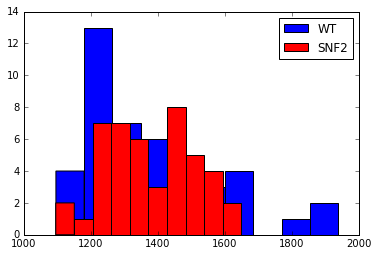

In [339]:
# lets look at individual genes a bit closer

gene = 'YCR009C'

snf2 = []
wt = []


for c in colnames_snf2:
    snf2.append(df.at[gene,c])
for c in colnames_WT:
    wt.append(df.at[gene,c])
        
h = plt.hist(wt, color = 'blue',label='WT')
h = plt.hist(snf2, color = 'red',label='SNF2')
plt.legend()

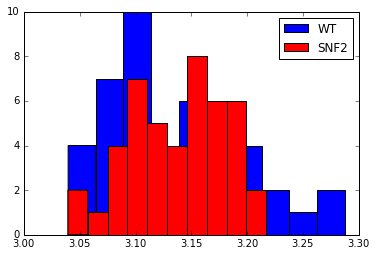

In [430]:
# log transform values

gene = 'YCR009C'

snf2 = []
wt = []


for c in colnames_snf2:
    snf2.append(np.log10(df.at[gene,c]))
for c in colnames_WT:
    wt.append(np.log10(df.at[gene,c]))
        
h = plt.hist(wt,color = 'blue',label='WT')
h = plt.hist(snf2,color = 'red',label='SNF2')
plt.legend()

In [434]:
samplesizes = [1,2,3,4,5,10,25,50,100]
trials = 1000
ave = 1000
var = 100

meandiffs = {}

for s in samplesizes:
    meandiffs[s] = []
    for t in range(0,trials):
        s1 = rv.rvs(size=s)
        s2 = rv.rvs(size=s)
        meandiffs[s].append(abs(np.mean(s1)-np.mean(s2)))
        
        


(array([ 6.28085469,  4.42822848,  4.04414744,  3.54710139,  1.71706819,
         1.26520814,  0.63260407,  0.33889504,  0.24852303,  0.09037201]),
 array([  3.09481561e-04,   4.45709736e-02,   8.88324657e-02,
          1.33093958e-01,   1.77355450e-01,   2.21616942e-01,
          2.65878434e-01,   3.10139926e-01,   3.54401418e-01,
          3.98662910e-01,   4.42924402e-01]),
 <a list of 10 Patch objects>)

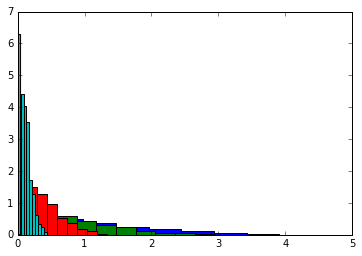

In [441]:
plt.hist(meandiffs[1], normed=True)
plt.hist(meandiffs[2], normed=True)
plt.hist(meandiffs[10], normed=True)
plt.hist(meandiffs[100], normed=True)

0.0 1.0


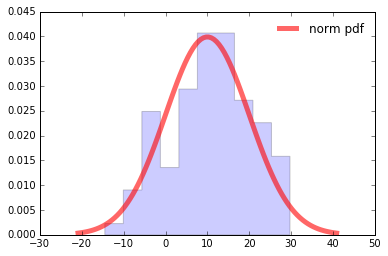

In [40]:
fig, ax = plt.subplots(1, 1)

mean, var, skew, kurt = norm.stats(moments='mvsk')

print (mean,var)
rv = norm(10,10)

x = np.linspace(rv.ppf(0.001),rv.ppf(0.999), 100)

ax.plot(x, rv.pdf(x),'r-', lw=5, alpha=0.6, label='norm pdf')

r = rv.rvs(size=100)
ax.hist(r, normed=True, histtype='stepfilled', bins = 10, alpha=0.2)
ax.legend(loc='best', frameon=False)
plt.show()

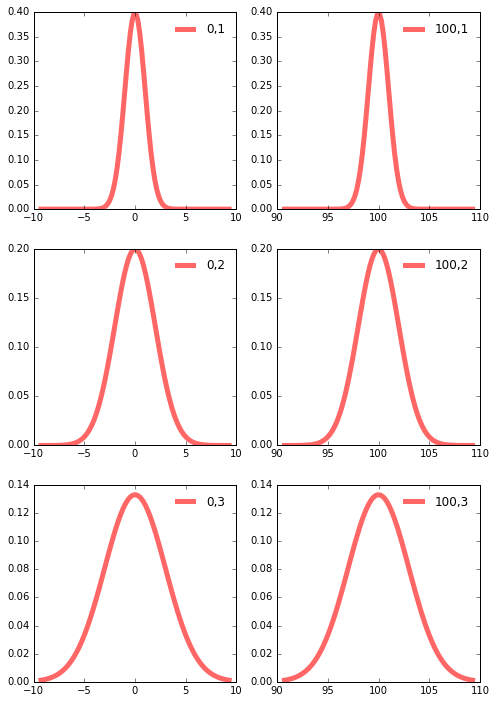

In [63]:
fig, axes = plt.subplots(3,2,figsize=(8,12))

for c,mean in enumerate([0,100]):
    for r,var in enumerate([1,2,3]):
        rv = norm(mean,var)
        x = np.linspace(norm(mean,3).ppf(0.001),norm(mean,3).ppf(0.999), 100)
        axes[r][c].plot(x, rv.pdf(x),'r-', lw=5, alpha=0.6, label="%d,%d" % (mean,var))
        axes[r][c].legend(loc='best', frameon=False)


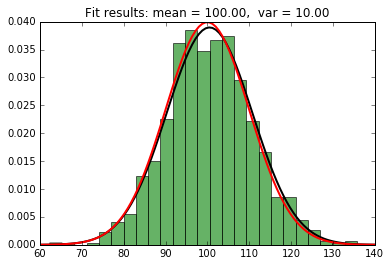

In [62]:
mean = 100
var = 10

norm_true = norm(mean,var)

s = 1000

data = norm_true.rvs(size=s)

mean_fit, var_fit = norm.fit(data)

plt.hist(data, bins=25, normed=True, alpha=0.6, color='g')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mean_fit, var_fit)
plt.plot(x, p, 'k', linewidth=2)
p = norm_true.pdf(x)
plt.plot(x, p, 'r', linewidth=2)
title = "Fit results: mean = %.2f,  var = %.2f" % (mean, var)
plt.title(title)

plt.show()

In [ ]:
mean = 100
var = 10

norm_true = norm(mean,var)

s = 1000

data = norm_true.rvs(size=s)

mean_fit, var_fit = norm.fit(data)

plt.hist(data, bins=25, normed=True, alpha=0.6, color='g')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mean_fit, var_fit)
plt.plot(x, p, 'k', linewidth=2)
p = norm_true.pdf(x)
plt.plot(x, p, 'r', linewidth=2)
title = "Fit results: mean = %.2f,  var = %.2f" % (mean, var)
plt.title(title)

plt.show()

(array([  27.,  103.,  204.,  257.,  203.,  125.,   54.,   21.,    4.,    2.]),
 array([  1.19587757,   3.08319991,   4.97052225,   6.85784459,
          8.74516693,  10.63248927,  12.51981161,  14.40713394,
         16.29445628,  18.18177862,  20.06910096]),
 <a list of 10 Patch objects>)

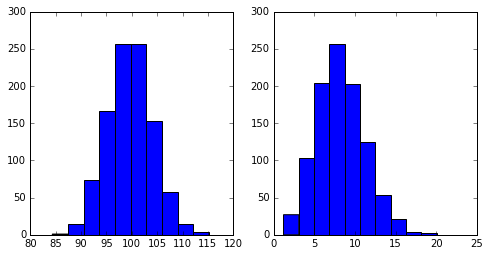

In [76]:
mean = 100
var = 10

norm_true = norm(mean,var)

trials = 1000
s = 5
mean_fits = []
var_fits = []

for t in range(0,trials):
    data = norm_true.rvs(size=s)
    mean_fit, var_fit = norm.fit(data)
    mean_fits.append(mean_fit)
    var_fits.append(var_fit)
    
fig, axes = plt.subplots(1,2,figsize=(8,4))

axes[0].hist(mean_fits)
axes[1].hist(var_fits)

(array([    0.,     0.,     0.,     0.,     0.,  1000.,     0.,     0.,
            0.,     0.]),
 array([  9.5,   9.6,   9.7,   9.8,   9.9,  10. ,  10.1,  10.2,  10.3,
         10.4,  10.5]),
 <a list of 10 Patch objects>)

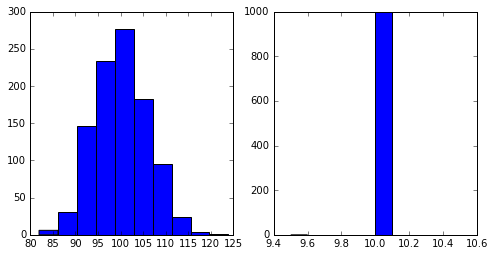

In [94]:
mean = 100
var = 10

norm_true = norm(mean,var)

trials = 1000
s = 3
mean_fits = []
var_fits = []

for t in range(0,trials):
    data = norm_true.rvs(size=s)
    mean_fit, var_fit = norm.fit(data, fscale = 10)
    mean_fits.append(mean_fit)
    var_fits.append(var_fit)
    
fig, axes = plt.subplots(1,2,figsize=(8,4))

axes[0].hist(mean_fits)
axes[1].hist(var_fits)

(array([    0.,     0.,     0.,     0.,     0.,  1000.,     0.,     0.,
            0.,     0.]),
 array([ 0.5,  0.6,  0.7,  0.8,  0.9,  1. ,  1.1,  1.2,  1.3,  1.4,  1.5]),
 <a list of 10 Patch objects>)

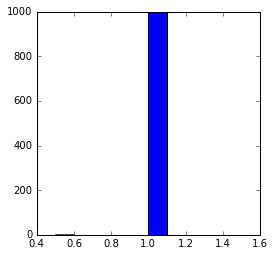

In [107]:
mean = 100
var = 10

norm_true = norm(mean,var)

trials = 1000
s = 100
mean_fits = []
mean_fits_fvar = []
mean_true = []

for t in range(0,trials):
    data = norm_true.rvs(size=s)
    mean_fit, var_fit = norm.fit(data)
    mean_fits.append(mean_fit)
    mean_fit, var_fit = norm.fit(data, fscale = 100)
    mean_fits_fvar.append(mean_fit)
    mean_true.append(np.mean(data))
    
fig, axes = plt.subplots(1,1,figsize=(4,4))

x = np.array(mean_fits)/np.array(mean_true)
#axes.scatter(mean_fits,mean_true)
axes.hist(x)

In [102]:
norm.fit(data, floc = 10)

(10, 89.049761401941808)

In [88]:
mean_fits, mean_fits_fvarnorm.fit(data, fscale = 100)

([104.07719053057093,
  87.915138691598358,
  109.71588827515691,
  108.4257399339958,
  110.70294987469248,
  102.5765851516035,
  98.914427375938828,
  99.717518501160782,
  97.683157696193575,
  95.246989937323335,
  102.04555510748807,
  94.986630357851595,
  94.73694339995312,
  86.883694910636962,
  84.078123955819819,
  98.422804403934819,
  90.343036095466459,
  90.239515512796643,
  102.58314043025717,
  97.779645565959996,
  110.14141503735537,
  97.987153963797454,
  105.6277987419646,
  94.174196323031964,
  105.16061918650044,
  89.943037972398315,
  93.44245642043856,
  102.44679194311161,
  109.6842633437586,
  97.165089833181383,
  99.676528109500026,
  107.725197752686,
  101.61314962787969,
  96.72822181587027,
  102.27136717481184,
  86.407966400070819,
  87.058592737390825,
  94.442986246395293,
  114.85818491964665,
  111.20621389152686,
  99.206756269245432,
  104.47549803436169,
  95.956524224894537,
  102.86489786285722,
  102.99665442541985,
  105.7673858099993

In [113]:
import statsmodels.api as sm

/Users/eisen/anaconda/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
